In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx

# parameters
path = "./results/empirical_results/"
plot_period=1000

# 1 data preprocessing

In [2]:
# load fake data (exposure)
df_exposures = ef.get_df_exposures(lines=int(1e5))
dic_rev_repo_exp_adj = ep.build_from_exposures(df_exposures=df_exposures,path=f"{path}data/")

# build finrep data @NA: add here a read csv of the data with the total assets
df_finrep = ef.get_df_finrep()

100%|██████████| 100000/100000 [00:34<00:00, 2935.10it/s]


In [2]:
# pickle (faster)
dic_rev_repo_exp_adj = ep.load_dic_obs_matrix_reverse_repo(path=f"{path}data/")
df_finrep = ef.get_df_finrep()

# 2 metrics measurement

In [3]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static view, distribution across banks 

In [4]:
# accounting data per bank on a given date (to be filled in with FINREP data => should I do a proposal ? can we confirm the form of the FINREP table )
df_banks = pd.read_csv("./results/single_run/df_banks.csv", index_col=0)


# add a computation of the ratios over total assets

In [5]:
# plot all power law tests
gx.plot_step_all_power_law(df_banks, f"{path}accounting_view/power_laws/")

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: inva

#### B - dynamic view, distribution across time

In [6]:
# build arr_total_assets
arr_total_assets = ep.build_arr_total_assets(df_finrep, f"{path}accounting_view/")

deposits shocks: donnée d'entrée : panel data avec date, lei, montant de depot   (frequence journaliere)

#### C - mixed view

## 2.2. exposure view

In [7]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

In [ ]:
# get aggregated adjency matrices
dic_arr_binary_adj = ep.build_rolling_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=f"{path}data/")

In [8]:
# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=f"{path}data/")

### 2.2.1 jaccard

In [9]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 20833/20833 [00:02<00:00, 8357.29it/s]


### 2.2.2 density

In [10]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 20833/20833 [00:02<00:00, 8648.99it/s]


### 2.2.3 degree distribution 

In [11]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 20834/20834 [00:04<00:00, 5006.62it/s]


### 2.2.4 degree stats

In [12]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=path)
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 20833/20833 [00:07<00:00, 2661.61it/s]


### 2.2.5 degree per asset

In [15]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep["date"])
finrep_bank_ids = list(set(df_finrep["lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    arr_total_assets,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_days=finrep_days, 
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 core periphery

In [16]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

run core-periphery tests
core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 191.73it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1040.99it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1068.33it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1003.95it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1054.19it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1000.84it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 998.64it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 998.69it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 980.41it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1048.89it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1031.42it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1039.56it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1038.16it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 905.33it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 989.00it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1033.95it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1035.43it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1038.95it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 984.48it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 911.85it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1038.74it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1030.59it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 583.00it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.66it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.73it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.70it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.78it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.85it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 549.53it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 549.44it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.73it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 552.79it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.89it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.03it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.96it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.02it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 552.04it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.61it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.26it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 562.91it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.75it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 558.79it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.24it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.22it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 192.24it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.49it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.40it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.58it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.54it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.23it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.53it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.58it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.91it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.95it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.12it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.02it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.08it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.06it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.14it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.51it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.53it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.53it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 583.43it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 532.95it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.48it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.85it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.22it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.20it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.06it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.74it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.56it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.07it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.79it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.60it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.02it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.22it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.24it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.21it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.24it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.94it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.36it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.78it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.19it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.11it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 192.39it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.36it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.85it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.04it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.08it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.16it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.10it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.11it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.13it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.15it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.11it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.11it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.10it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.06it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.08it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.04it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.11it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.14it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.93it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.13it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.04it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.16it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.63it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.19it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.95it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 507.56it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 507.34it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.84it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.36it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 507.79it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.55it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.71it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 507.90it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.05it/s]

test on day 2052-11-08 00:00:00



100%|██████████| 100/100 [00:00<00:00, 507.54it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.02it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.20it/s]

test on day 2061-01-25 00:00:00

100%|██████████| 100/100 [00:00<00:00, 508.59it/s]

test on day 2063-10-22 00:00:00



100%|██████████| 100/100 [00:00<00:00, 508.10it/s]

test on day 2066-07-18 00:00:00



100%|██████████| 100/100 [00:00<00:00, 507.67it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 507.48it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 506.11it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 525.08it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 534.56it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 191.03it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.05it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.47it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.36it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.82it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.94it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.59it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.89it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.79it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.76it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.85it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.97it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.01it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.94it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.75it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.02it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.07it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.16it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.20it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.16it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.14it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.10it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 591.50it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.00it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.35it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.29it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.01it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.55it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.40it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.91it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.62it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.67it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.60it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.84it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.78it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.91it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.13it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.39it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.71it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.02it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.28it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.02it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.70it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.72it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1027.05it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1026.17it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1034.99it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1026.86it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1027.70it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 984.21it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 990.13it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1033.85it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1027.13it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1029.86it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 940.62it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 987.45it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1026.50it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1024.91it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1029.28it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1033.24it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1035.08it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1037.10it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1038.20it/s]

test on day 2072-01-08 00:00:00



100%|██████████| 100/100 [00:00<00:00, 1022.51it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1021.61it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1095.89it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.12it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.75it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.16it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.48it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.92it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 549.80it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.25it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.66it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.59it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.13it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.82it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 558.82it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.66it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.62it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.78it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.66it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 552.60it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.61it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.67it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.74it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.13it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.84it/s]


## 2.3 transaction view

In [17]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

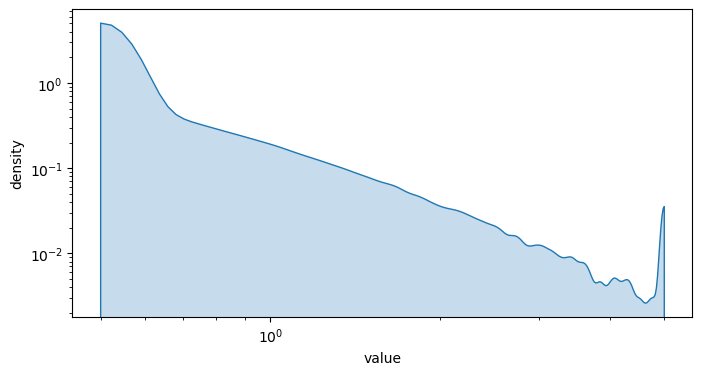

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

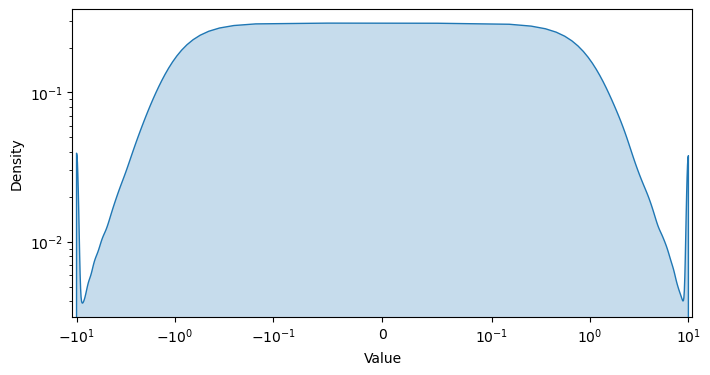

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

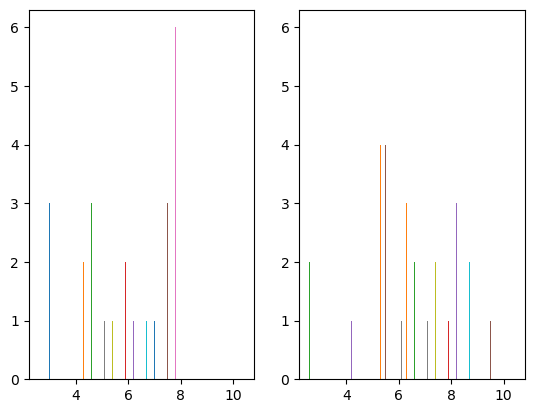

In [20]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


2.854514603515238
1.0373019710358102


<AxesSubplot: >

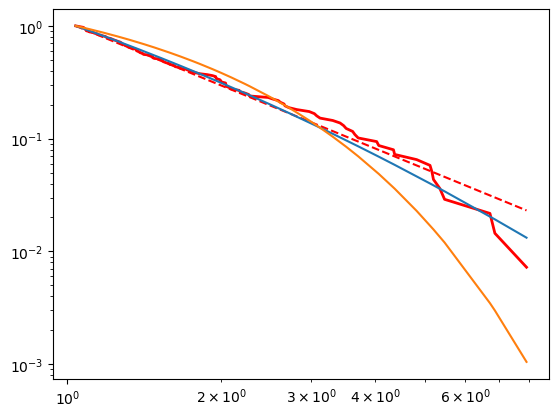

In [21]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
fit = powerlaw.Fit(sr_data)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
R, p = fit.distribution_compare('power_law', 'exponential')
fig2 = fit.plot_ccdf(color = "r", linewidth = 2)
fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
fit.lognormal.plot_ccdf(ax=fig2)
fit.exponential.plot_ccdf(ax=fig2)